In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf
import matplotlib.pyplot as plt
from pandas import *
from pandas_datareader import data as pdr
import tensorflow as tf
import seaborn as sns
yf.pdr_override()
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
# Tickers
tickers = ['^GSPC', '^VIX', '^TNX', 'EURUSD=X', 'EURJPY=X', 'GBPJPY=X', 'EURGBP=X', 'GBPUSD=X']

# dates
startdate = '2015-1-1'
train_end = '2017-12-31'
test_start = '2018-01-01'
enddate = '2018-12-31'

# data Close
data_close = pdr.get_data_yahoo(tickers, start=startdate, end=enddate)['Adj Close']
print('\n--- Full dataset')
display(data_close)

# data returns
data = data_close.shift(1) / data_close - 1
print('\n--- Full dataset returns')
display(data)

# Sets
data_train = data[startdate:train_end].dropna()
data_test = data[test_start:enddate].dropna()
print('\n--- Train set unadjusted')
display(data_train)
print('\n--- Test set unadjusted')
display(data_test)

# mu sigma train
mu_train = data_train.mean()
sigma_train = data_train.std()
print('\n--- mu train:')
display(pd.DataFrame(mu_train, columns=['Train set Mean']))
print('\n--- sigma train:')
display(pd.DataFrame(sigma_train, columns=['Train set st dev']))

# Final sets
data_train_prod = (data_train - mu_train) / sigma_train
data_test_prod = (data_test - mu_train) / sigma_train
print('\n--- Train set adjusted')
display(data_train_prod)
print('\n--- Test set adjusted')
display(data_test_prod)

[*********************100%***********************]  8 of 8 completed

--- Full dataset


,EURGBP=X,EURJPY=X,EURUSD=X,GBPJPY=X,GBPUSD=X,^GSPC,^TNX,^VIX
Date,,,,,,,,
2015-01-01,0.77616,144.779999,1.209863,186.429993,1.558094,NaN,NaN,NaN
2015-01-02,0.77590,144.929993,1.208941,186.764999,1.557972,2058.199951,2.123,17.790001
2015-01-05,0.78148,143.860001,1.194643,184.078003,1.528491,2020.579956,2.039,19.920000
2015-01-06,0.78240,142.557007,1.193902,182.205002,1.525832,2002.609985,1.963,21.120001
2015-01-07,0.78444,140.912003,1.187536,179.625000,1.513798,2025.900024,1.954,19.309999
...,...,...,...,...,...,...,...,...
2018-12-25,0.89660,125.769997,1.140394,140.169998,1.271084,NaN,NaN,NaN
2018-12-26,0.89949,126.001999,1.141553,140.052994,1.268875,2467.699951,2.797,30.410000
2018-12-27,0.89816,126.404999,1.136131,140.695999,1.264878,2488.830078,2.743,29.959999



--- Full dataset returns


,EURGBP=X,EURJPY=X,EURUSD=X,GBPJPY=X,GBPUSD=X,^GSPC,^TNX,^VIX
Date,,,,,,,,
2015-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-02,0.000335,-0.001035,0.000762,-0.001794,0.000078,NaN,NaN,NaN
2015-01-05,-0.007140,0.007438,0.011968,0.014597,0.019288,0.018618,0.041197,-0.106928
2015-01-06,-0.001176,0.009140,0.000621,0.010280,0.001742,0.008973,0.038716,-0.056818
2015-01-07,-0.002601,0.011674,0.005361,0.014363,0.007950,-0.011496,0.004606,0.093734
...,...,...,...,...,...,...,...,...
2018-12-25,0.002733,0.004150,-0.002729,0.002048,-0.004870,NaN,NaN,NaN
2018-12-26,-0.003213,-0.001841,-0.001015,0.000835,0.001741,NaN,NaN,NaN
2018-12-27,0.001481,-0.003188,0.004772,-0.004570,0.003159,-0.008490,0.019686,0.015020



--- Train set unadjusted


,EURGBP=X,EURJPY=X,EURUSD=X,GBPJPY=X,GBPUSD=X,^GSPC,^TNX,^VIX
Date,,,,,,,,
2015-01-05,-0.007140,0.007438,0.011968,0.014597,0.019288,0.018618,0.041197,-0.106928
2015-01-06,-0.001176,0.009140,0.000621,0.010280,0.001742,0.008973,0.038716,-0.056818
2015-01-07,-0.002601,0.011674,0.005361,0.014363,0.007950,-0.011496,0.004606,0.093734
2015-01-08,0.001455,-0.001736,0.003325,-0.002986,0.002013,-0.017574,-0.030754,0.135215
2015-01-09,0.002137,-0.000623,0.003385,-0.002861,0.001299,0.008475,0.022831,-0.030769
...,...,...,...,...,...,...,...,...
2017-12-21,-0.004425,-0.005636,-0.003102,-0.001215,0.001111,-0.001982,0.006449,0.010395
2017-12-22,0.002370,0.001057,0.001758,-0.001339,-0.000628,0.000458,-0.001610,-0.028283
2017-12-27,0.000981,0.002093,0.001235,0.001050,0.000107,-0.000790,0.021955,-0.021012



--- Test set unadjusted


,EURGBP=X,EURJPY=X,EURUSD=X,GBPJPY=X,GBPUSD=X,^GSPC,^TNX,^VIX
Date,,,,,,,,
2018-01-03,0.001939,0.000288,-0.004300,-0.001586,-0.006242,-0.006358,0.007356,0.067760
2018-01-04,-0.001845,0.001235,0.004415,0.002991,0.006281,-0.004012,-0.002446,-0.007592
2018-01-05,-0.001640,-0.006524,-0.004840,-0.004567,-0.003067,-0.006985,-0.009289,0.000000
2018-01-08,0.004151,-0.000595,0.002607,-0.005019,-0.001694,-0.001660,-0.001613,-0.031513
2018-01-09,0.005181,0.005678,0.005597,0.000580,0.000339,-0.001301,-0.025923,-0.055556
...,...,...,...,...,...,...,...,...
2018-12-19,0.000768,0.000461,-0.002247,-0.000316,-0.003103,0.015636,0.016919,0.000000
2018-12-20,-0.003260,-0.000187,-0.001240,0.002994,0.002151,0.016025,-0.003944,-0.098661
2018-12-21,-0.002710,0.005230,-0.005877,0.007989,-0.003308,0.021021,-0.001075,-0.057456



--- mu train:


,Train set Mean
EURGBP=X,-0.000178
EURJPY=X,0.000090
EURUSD=X,-0.000040
GBPJPY=X,0.000305
GBPUSD=X,0.000162
^GSPC,-0.000278
^TNX,-0.000102
^VIX,0.004274



--- sigma train:


,Train set st dev
EURGBP=X,0.006369
EURJPY=X,0.006734
EURUSD=X,0.006126
GBPJPY=X,0.008712
GBPUSD=X,0.006712
^GSPC,0.007816
^TNX,0.021720
^VIX,0.076458



--- Train set adjusted


,EURGBP=X,EURJPY=X,EURUSD=X,GBPJPY=X,GBPUSD=X,^GSPC,^TNX,^VIX
Date,,,,,,,,
2015-01-05,-1.093199,1.091207,1.960396,1.640579,2.849289,2.417657,1.901404,-1.454415
2015-01-06,-0.156704,1.344024,0.107978,1.144988,0.235404,1.183619,1.787208,-0.799030
2015-01-07,-0.380396,1.720307,0.881667,1.613743,1.160138,-1.435322,0.216765,1.170050
2015-01-08,0.256436,-0.271073,0.549374,-0.377776,0.275753,-2.212937,-1.411214,1.712578
2015-01-09,0.363391,-0.105846,0.559180,-0.363456,0.169370,1.119871,1.055853,-0.458333
...,...,...,...,...,...,...,...,...
2017-12-21,-0.666800,-0.850231,-0.499908,-0.174502,0.141348,-0.218008,0.301620,0.080056
2017-12-22,0.400024,0.143620,0.293546,-0.188687,-0.117818,0.094188,-0.069402,-0.425814
2017-12-27,0.182006,0.297562,0.208142,0.085585,-0.008242,-0.065575,1.015529,-0.330724



--- Test set adjusted


,EURGBP=X,EURJPY=X,EURUSD=X,GBPJPY=X,GBPUSD=X,^GSPC,^TNX,^VIX
Date,,,,,,,,
2018-01-03,0.332323,0.029450,-0.695440,-0.217051,-0.954163,-0.777944,0.343372,0.830332
2018-01-04,-0.261786,0.170069,0.727342,0.308306,0.911624,-0.477831,-0.107909,-0.155201
2018-01-05,-0.229555,-0.982101,-0.783588,-0.559244,-0.481116,-0.858102,-0.422970,-0.055901
2018-01-08,0.679619,-0.101651,0.432117,-0.611164,-0.276592,-0.176793,-0.069552,-0.468057
2018-01-09,0.841426,0.829883,0.920332,0.031541,0.026388,-0.130944,-1.188795,-0.782515
...,...,...,...,...,...,...,...,...
2018-12-19,0.148456,0.055117,-0.360317,-0.071280,-0.486547,2.036132,0.783642,-0.055901
2018-12-20,-0.483991,-0.041169,-0.195848,0.308682,0.296314,2.085826,-0.176879,-1.346294
2018-12-21,-0.397515,0.763300,-0.952851,0.882040,-0.517086,2.725055,-0.044765,-0.807372


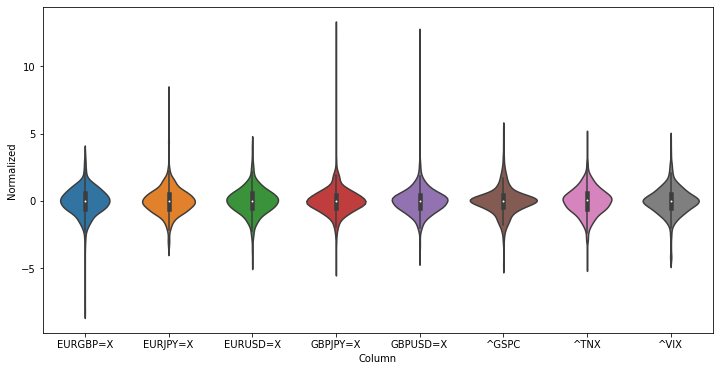

In [3]:
df_std = data_train_prod.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12,6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)

In [4]:
print(list(data_train_prod.columns))

['EURGBP=X', 'EURJPY=X', 'EURUSD=X', 'GBPJPY=X', 'GBPUSD=X', '^GSPC', '^TNX', '^VIX']


In [60]:
def evaluate_model(model, hist, inputs, labels, test_inputs, test_labels, acc=False):
    # Classification Logic
    if acc:
        display_columns = ['Naive (Train)', 'Naive (Test)', 'HITS (Train)', 'HITS (Val)']
        df = pd.DataFrame([], columns=display_columns)
        # Training
        pred = np.squeeze(model.predict(inputs))
        pred[pred >= 0.5] = 1
        pred[pred < 0.5] = 0
        hits = np.sum(pred == labels)/len(labels)
        naive_hits = np.sum(labels[1:] == labels[:-1])/(len(labels-1))
        
        # Validation
        pred_test = np.squeeze(model.predict(test_inputs))
        pred_test[pred_test >= 0.5] = 1
        pred_test[pred_test < 0.5] = 0
        test_hits = np.sum(pred_test == test_labels)/len(test_labels)
        naive_hits_test = np.sum(test_labels[1:] == test_labels[:-1])/(len(test_labels-1))
        
        df = df.append({key: val for key,val in zip(display_columns, 
                                                    [naive_hits, 
                                                     naive_hits_test, 
                                                     hits, 
                                                     test_hits])},
                      ignore_index=True)        
        
        #print(f'train hits: {hits} \n Test hits: {test_hits}')
        
    # Regression Logic
    else:
        display_columns = ['Naive (Train)', 'Naive (Test)', 'MASE (Train)', 'MASE (Val)']
        df = pd.DataFrame([], columns=display_columns)
        # Training
        naive_mae = mean_absolute_error(labels[1:], labels[:-1])
        std_mae = np.std(np.abs(np.squeeze(model.predict(inputs)) - labels))
        model_mae = mean_absolute_error(np.squeeze(model.predict(inputs)), labels) 
        mase = model_mae/naive_mae
        mase_std = std_mae/naive_mae
        #print('train', naive_mae, model_mae, std_mae, naive_mae, model_mae/naive_mae)
        
        # Validation
        naive_mae_test = mean_absolute_error(test_labels[1:], test_labels[:-1])
        std_mae_test = np.std(np.abs(np.squeeze(model.predict(test_inputs)) - test_labels))
        model_mae_test = mean_absolute_error(np.squeeze(model.predict(test_inputs)), test_labels)
        mase_test = model_mae_test/naive_mae_test
        mase_std_test = std_mae_test/naive_mae_test
        #print('test', model_mae_test, std_mae_test, naive_mae_test, mase_test)
        
        df = df.append({key: val for key,val in zip(display_columns, 
                                                    [naive_mae, naive_mae_test, 
                                                     f'{mase:0.2f} ({mase_std:0.2f})', 
                                                     f'{mase_test:0.2f} ({mase_std_test:0.2f})'])},
                      ignore_index=True)
        
    plt.figure()        
    plt.scatter(np.squeeze(model.predict(inputs)), labels)
    plt.title('training')
    plt.xlabel('prediction')
    plt.subplots()
    plt.scatter(np.squeeze(model.predict(test_inputs)), test_labels)
    plt.title('testing')
    plt.xlabel('prediction')
    pd.DataFrame(hist.history).plot()
    plt.show()
    return df

In [61]:
def window_data(data, window_size):
    last_index = len(data)-window_size
    
    trunc_data = [data[i:i+window_size] for i in range(last_index)]
    return np.dstack(trunc_data)
    
def gen_data(train, window, val, col=0, cls=False):
    val_data = train[-window:].append(val).values
    inputs = np.transpose(window_data(train.values, window), (2,0,1))
    labels = train.values[window:,col]
    val_inputs = np.transpose(window_data(val_data, window), (2,0,1))
    val_labels = val_data[window:,col]
    
    if cls==True:
        labels = labels > 0
        val_labels = val_labels > 0
        labels = labels.astype(int)
        val_labels = val_labels.astype(int)
    return (inputs,labels), (val_inputs, val_labels)

In [ ]:
def run_wrapper(model, window, train, test, cls=False, truth_idx=0, verbose=0):
    # if cls = True, runs HITS instead of MAE
    model.compile(loss=tf.keras.losses.MeanAbsoluteError(), optimizer=tf.keras.optimizers.Adam(1e-3))
    if verbose:
        model.summary()
    
    train, val = gen_data(train, window, test, cls=cls, col=truth_idx)
    hist = model.fit(*train, epochs=50, verbose=0, validation_data=val)
    data = evaluate_model(model, hist, *train, *val, acc=cls)
    return data

## Index Forecasting (Conditional)

In [63]:
num_features=3
num_timesteps=1
lstm_model_1 = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(num_timesteps, num_features)),
    tf.keras.layers.LSTM(10, kernel_regularizer=tf.keras.regularizers.l2(0.001), return_sequences=False),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=1)
])

num_timesteps=16
lstm_model_16 = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(num_timesteps, num_features)),
    tf.keras.layers.LSTM(10, kernel_regularizer=tf.keras.regularizers.l2(0.001), return_sequences=False),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=1)
])

num_timesteps=256
lstm_model_256 = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(num_timesteps, num_features)),
    tf.keras.layers.LSTM(10, kernel_regularizer=tf.keras.regularizers.l2(0.001), return_sequences=False),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=1)
])

In [64]:
idx_train = data_train_prod.loc[:, ['^GSPC', '^TNX', '^VIX']]
idx_test = data_test_prod.loc[:, ['^GSPC', '^TNX', '^VIX']]

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_24 (LSTM)               (None, 10)                560       
_________________________________________________________________
dropout_24 (Dropout)         (None, 10)                0         
_________________________________________________________________
dense_24 (Dense)             (None, 1)                 11        
Total params: 571
Trainable params: 571
Non-trainable params: 0
_________________________________________________________________


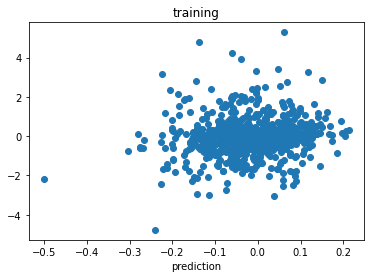

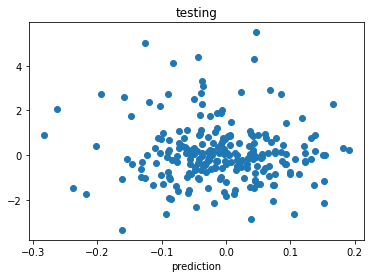

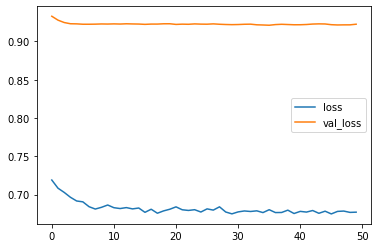

,Naive (Train),Naive (Test),MASE (Train),MASE (Val)
0,1.004346,1.247216,0.67 (0.72),0.74 (0.76)


In [65]:
window=1
lstm_model_1_data = run_wrapper(lstm_model_1, window, idx_train, idx_test, verbose=1)
lstm_model_1_data

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_25 (LSTM)               (None, 10)                560       
_________________________________________________________________
dropout_25 (Dropout)         (None, 10)                0         
_________________________________________________________________
dense_25 (Dense)             (None, 1)                 11        
Total params: 571
Trainable params: 571
Non-trainable params: 0
_________________________________________________________________


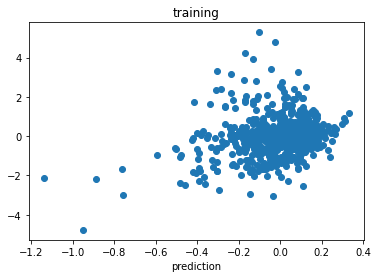

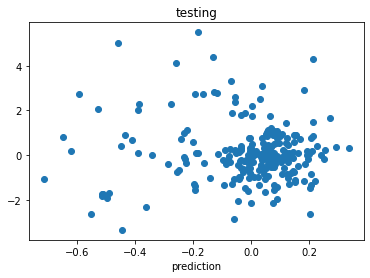

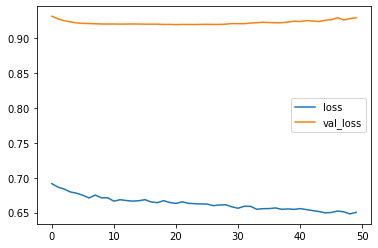

,Naive (Train),Naive (Test),MASE (Train),MASE (Val)
0,0.993952,1.247216,0.65 (0.71),0.74 (0.77)


In [66]:
window=16
lstm_model_16_data = run_wrapper(lstm_model_16, window, idx_train, idx_test, verbose=1)
lstm_model_16_data

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_23 (LSTM)               (None, 10)                560       
_________________________________________________________________
dropout_23 (Dropout)         (None, 10)                0         
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 11        
Total params: 571
Trainable params: 571
Non-trainable params: 0
_________________________________________________________________


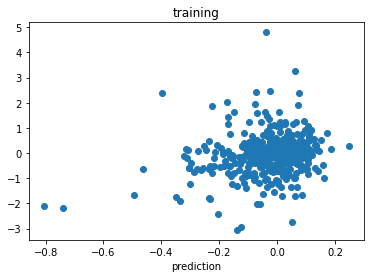

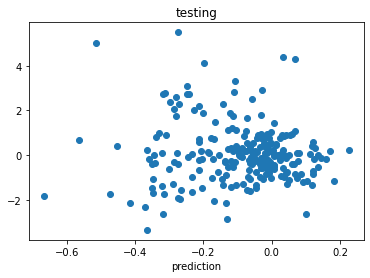

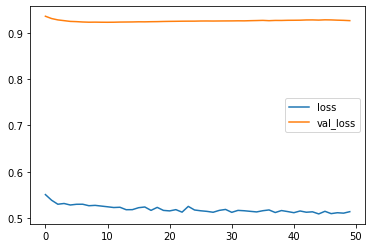

,Naive (Train),Naive (Test),MASE (Train),MASE (Val)
0,0.800016,1.247216,0.63 (0.71),0.74 (0.78)


In [59]:
window=256
lstm_model_256_data = run_wrapper(lstm_model_256, window, idx_train, idx_test, verbose=1)
lstm_model_256_data

## Index Forecasting (Unconditional)

## Index Forecasting Classification (Conditional)

In [67]:
num_features=3
num_timesteps=1
class_lstm_model_1 = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(num_timesteps, num_features)),
    tf.keras.layers.LSTM(25, return_sequences=False),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(units=1, activation='sigmoid'),
])

num_timesteps=16
class_lstm_model_16 = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(num_timesteps, num_features)),
    tf.keras.layers.LSTM(25, return_sequences=False),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(units=1, activation='sigmoid')
])

num_timesteps=256
class_lstm_model_256 = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(num_timesteps, num_features)),
    tf.keras.layers.LSTM(25, return_sequences=False),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(units=1, activation='sigmoid')
])

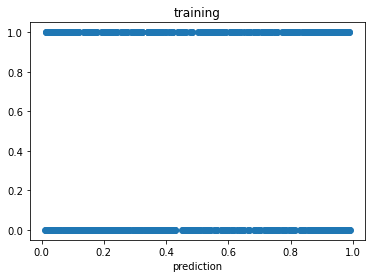

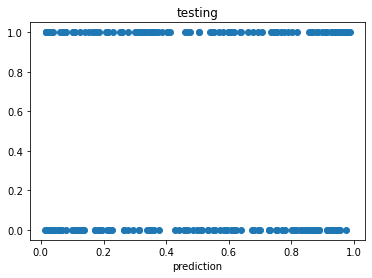

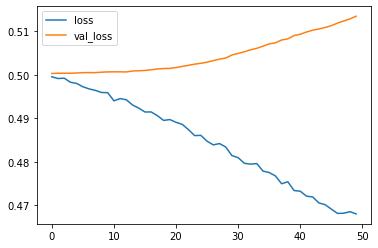

,Naive (Train),Naive (Test),HITS (Train),HITS (Val)
0,0.460251,0.518987,0.553696,0.468354


In [68]:
window=1
class_lstm_model_1_data = run_wrapper(class_lstm_model_1, window, idx_train, idx_test, cls=True)
class_lstm_model_1_data

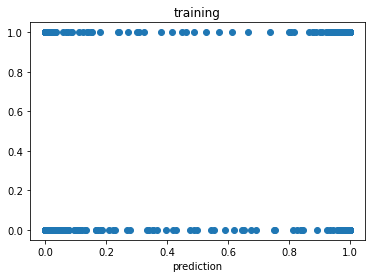

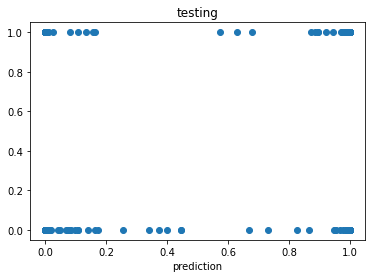

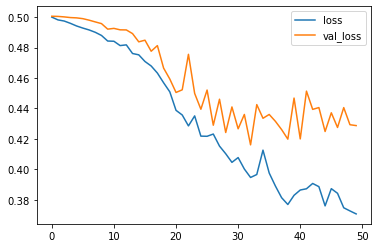

,Naive (Train),Naive (Test),HITS (Train),HITS (Val)
0,0.458689,0.518987,0.638177,0.586498


In [69]:
window=16
class_lstm_model_16_data = run_wrapper(class_lstm_model_16, window, idx_train, idx_test, cls=True)
class_lstm_model_16_data

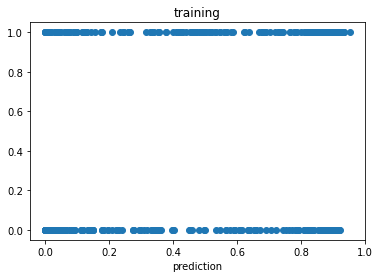

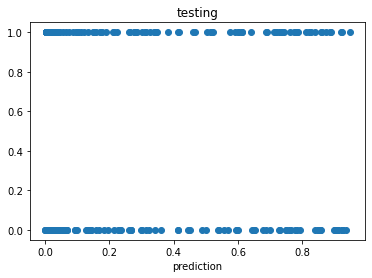

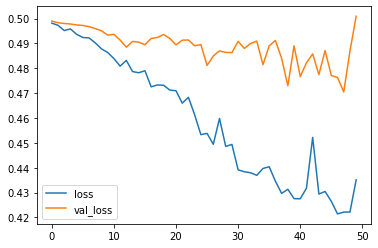

,Naive (Train),Naive (Test),HITS (Train),HITS (Val)
0,0.463203,0.518987,0.588745,0.49789


In [70]:
window=256
class_lstm_model_256_data = run_wrapper(class_lstm_model_256, window, idx_train, idx_test, cls=True)
class_lstm_model_256_data

## Index Forecasting Classification (Unconditional)

## Exchange Rate Forecasting (Conditional)

In [17]:
num_features=5
num_timesteps=1
er_lstm_model_1 = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(num_timesteps, num_features)),
    tf.keras.layers.LSTM(25, return_sequences=False),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(units=1)
])

num_timesteps=16
er_lstm_model_16 = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(num_timesteps, num_features)),
    tf.keras.layers.LSTM(25, return_sequences=False),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(units=1)
])

num_timesteps=256
er_lstm_model_256 = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(num_timesteps, num_features)),
    tf.keras.layers.LSTM(25, return_sequences=False),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(units=1)
])

In [18]:
er_columns = ['EURGBP=X', 'EURJPY=X', 'EURUSD=X', 'GBPJPY=X', 'GBPUSD=X']
er_train = data_train_prod.loc[:, er_columns]
er_test = data_test_prod.loc[:, er_columns]

In [19]:
er_test.diff().abs().mean()

EURGBP=X    0.646606
EURJPY=X    0.858760
EURUSD=X    0.844043
GBPJPY=X    0.819481
GBPUSD=X    0.883561
dtype: float64

EURGBP=X


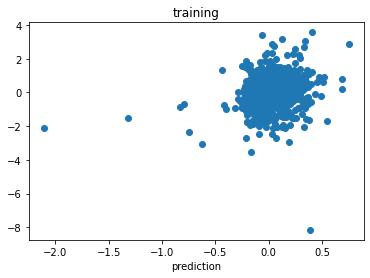

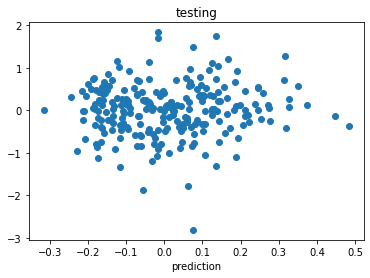

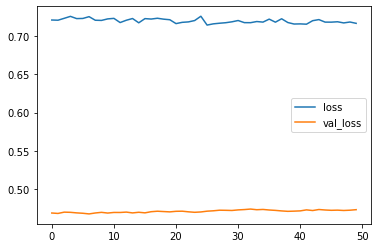

EURJPY=X


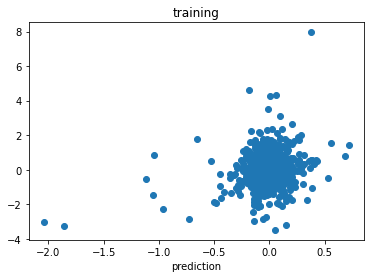

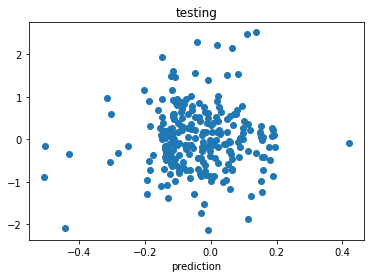

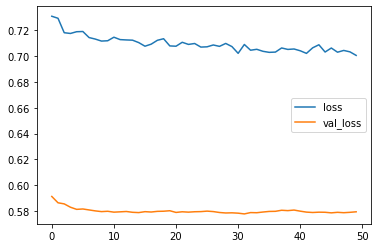

EURUSD=X


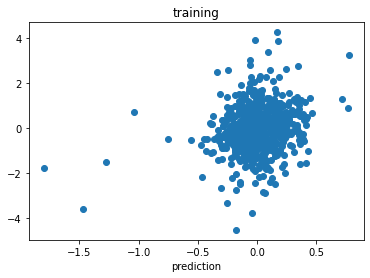

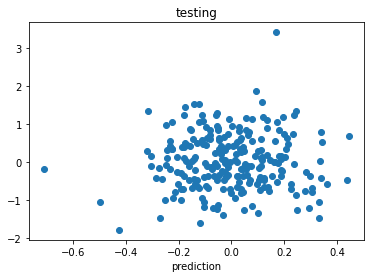

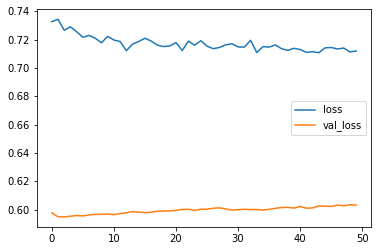

GBPJPY=X


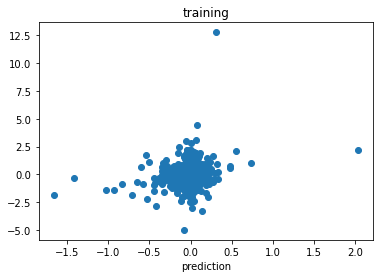

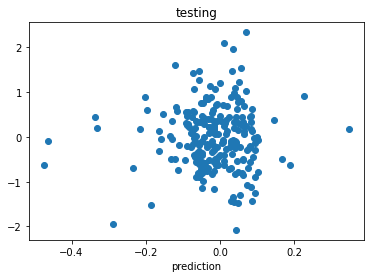

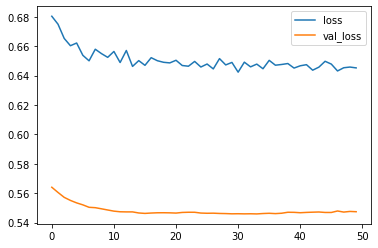

GBPUSD=X


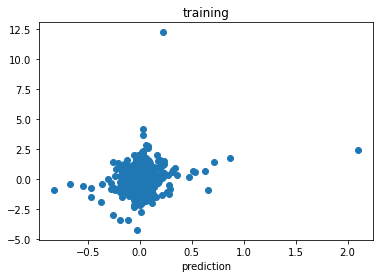

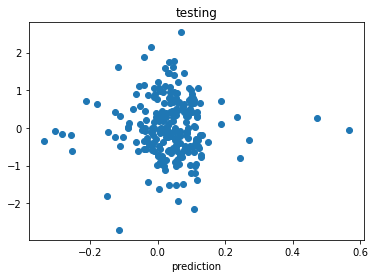

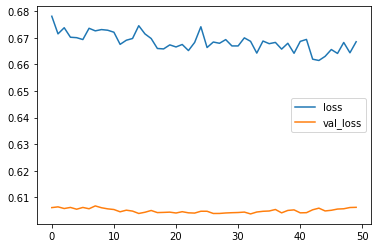

In [74]:
window=1
er_lstm_model_1_data = pd.DataFrame([])
for i in range(5):
    print(er_columns[i])
    data = run_wrapper(er_lstm_model_1, window, er_train, er_test, truth_idx=i)
    er_lstm_model_1_data = er_lstm_model_1_data.append(data)
    
er_lstm_model_1_data.index = [er_columns[i] for i in range(5)]

In [75]:
er_lstm_model_1_data

,Naive (Train),Naive (Test),MASE (Train),MASE (Val)
EURGBP=X,1.062889,0.646606,0.67 (0.63),0.73 (0.61)
EURJPY=X,1.075619,0.858760,0.65 (0.63),0.67 (0.58)
EURUSD=X,1.092993,0.844043,0.65 (0.61),0.71 (0.53)
GBPJPY=X,0.959938,0.819481,0.67 (0.77),0.67 (0.53)
GBPUSD=X,0.993231,0.883561,0.67 (0.72),0.69 (0.56)


EURGBP=X


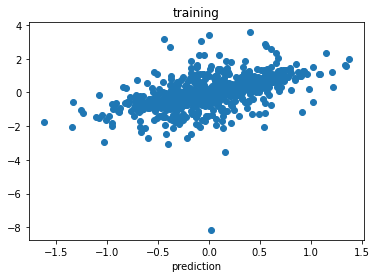

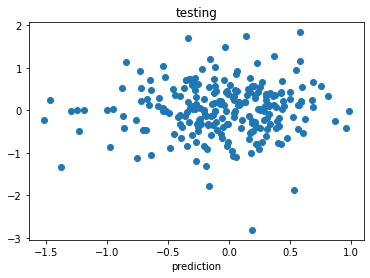

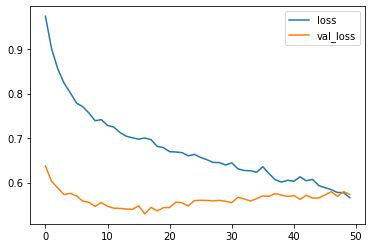

EURJPY=X


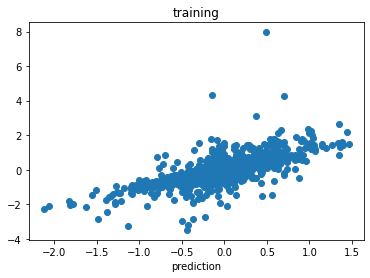

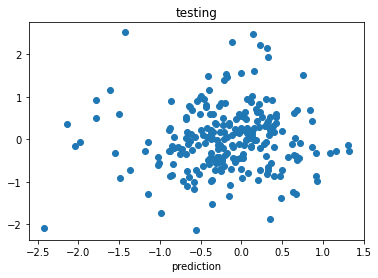

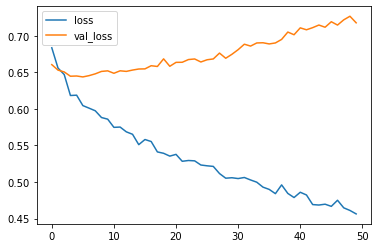

EURUSD=X


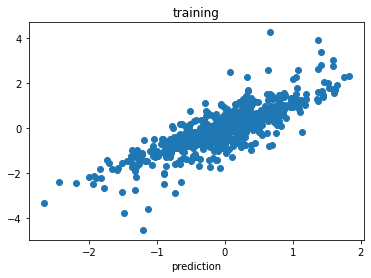

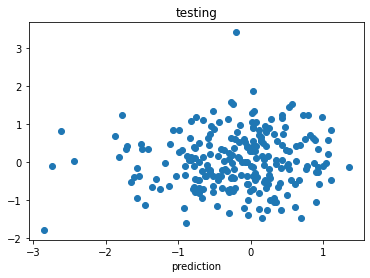

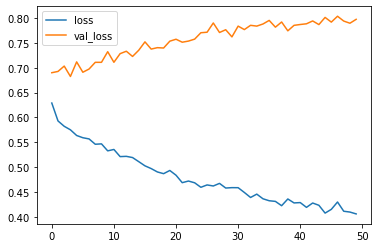

GBPJPY=X


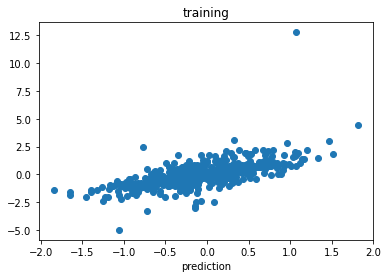

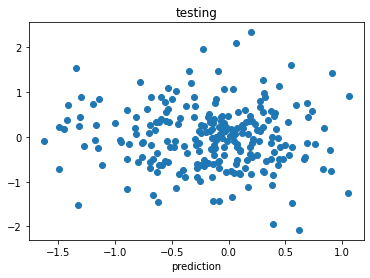

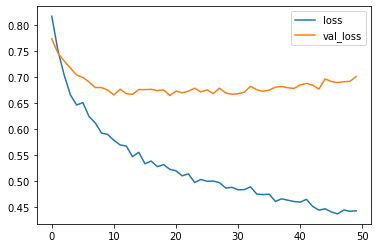

GBPUSD=X


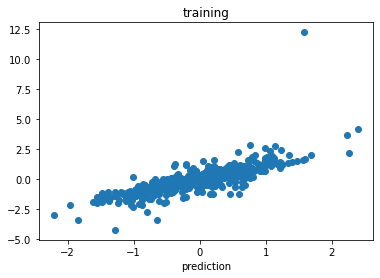

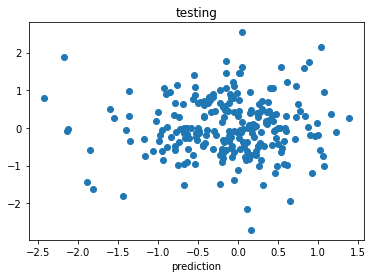

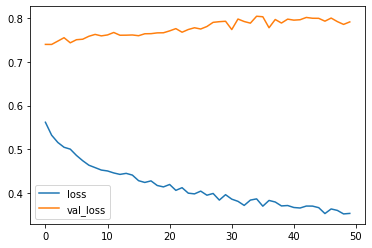

In [79]:
window=16
er_lstm_model_16_data = pd.DataFrame([])
for i in range(5):
    print(er_columns[i])
    data = run_wrapper(er_lstm_model_16, window, er_train, er_test, truth_idx=i)
    er_lstm_model_16_data = er_lstm_model_16_data.append(data)
    
er_lstm_model_16_data.index = [er_columns[i] for i in range(5)]


In [80]:
er_lstm_model_16_data

,Naive (Train),Naive (Test),MASE (Train),MASE (Val)
EURGBP=X,1.065658,0.646606,0.52 (0.60),0.89 (0.73)
EURJPY=X,1.055305,0.858760,0.40 (0.53),0.84 (0.74)
EURUSD=X,1.082116,0.844043,0.33 (0.40),0.95 (0.75)
GBPJPY=X,0.952392,0.819481,0.42 (0.68),0.86 (0.71)
GBPUSD=X,0.995971,0.883561,0.31 (0.54),0.90 (0.71)


EURGBP=X


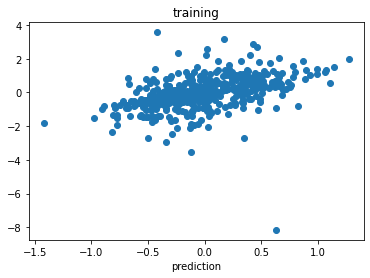

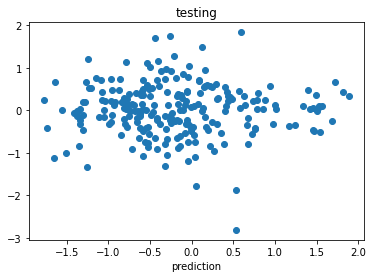

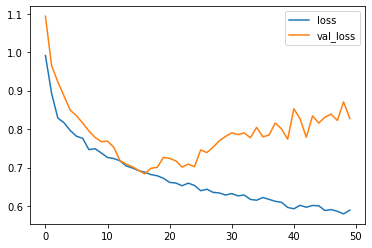

EURJPY=X


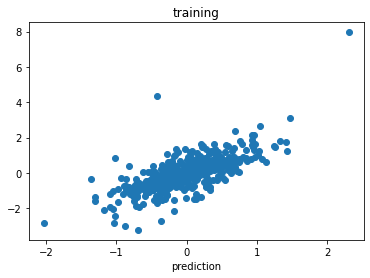

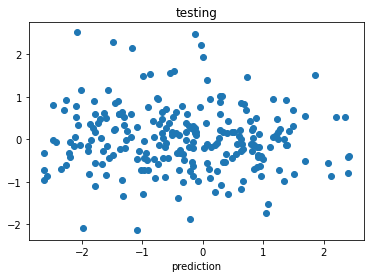

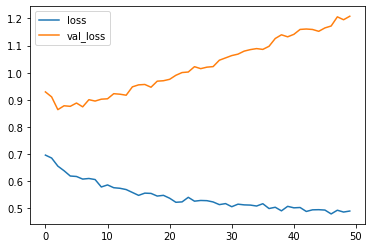

EURUSD=X


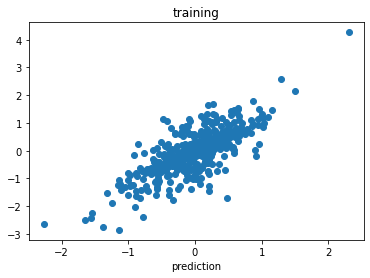

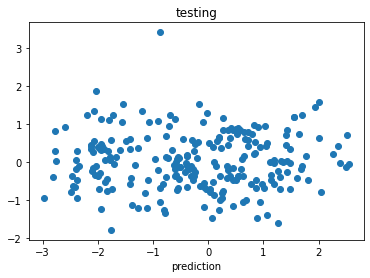

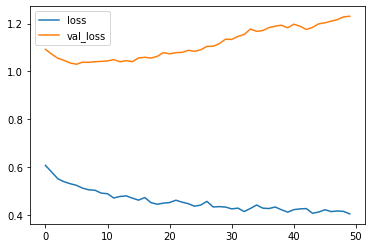

GBPJPY=X


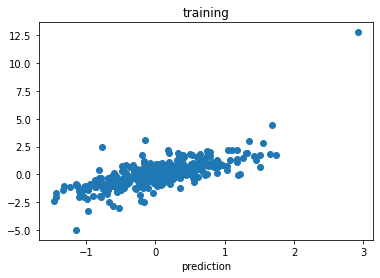

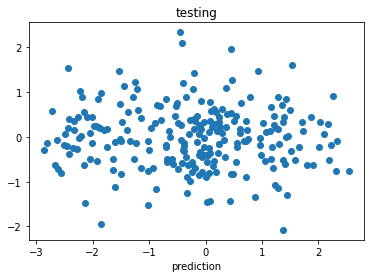

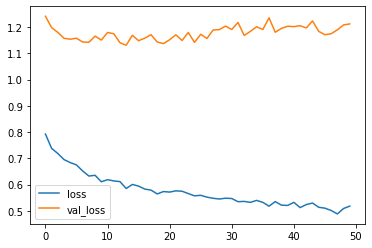

GBPUSD=X


In [ ]:
window=256
er_lstm_model_256_data = pd.DataFrame([])
for i in range(5):
    print(er_columns[i])
    data = run_wrapper(er_lstm_model_256, window, er_train, er_test, truth_idx=i)
    er_lstm_model_256_data = er_lstm_model_256_data.append(data)
    
er_lstm_model_256_data.index = [er_columns[i] for i in range(5)]


In [ ]:
er_lstm_model_256_data